In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rrcf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Read csv file
df = pd.read_csv("nyewasco_data.csv")
df.head(3)

,Unnamed: 0,time,turbidity,pH
0,0,2020-11-04 12:00:00.00+00:00,21,7.5
1,1,2020-11-04 14:00:00.00+00:00,20,7.5
2,2,2020-11-04 16:00:00.00+00:00,18,7.5


In [4]:
# Convert dataframe to array
turbidity_train= np.array(df['turbidity'])


In [5]:
# Set tree parameters
num_trees = 40
shingle_size = 1
tree_size = 256


In [7]:
# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)


In [10]:
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(turbidity_train, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

In [12]:
%%time
# Display prediction result

for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point
        # (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among
        # all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

Wall time: 1.17 s


In [13]:
# Convert score dictionary to data frame.
turbidity_result = pd.DataFrame.from_dict(avg_codisp,'index')

In [16]:
# Merge score with data.
df['Score'] = turbidity_result

In [19]:
#Try different values of threshold to get anomalies.
anomalies = df.loc[df['Score']>50] # wa 120, changed to 50
anomalies

,Unnamed: 0,time,turbidity,pH,Score
113,157,2020-11-13 22:00:00.00+00:00,65,7.5,63.685659
123,170,2020-11-14 18:00:00.00+00:00,84,7.4,50.882591
124,171,2020-11-14 20:00:00.00+00:00,150,7.4,83.963790


In [20]:
len(anomalies)

3

Text(0.5, 1.0, 'Temperature data (red) and anomaly score (blue)')

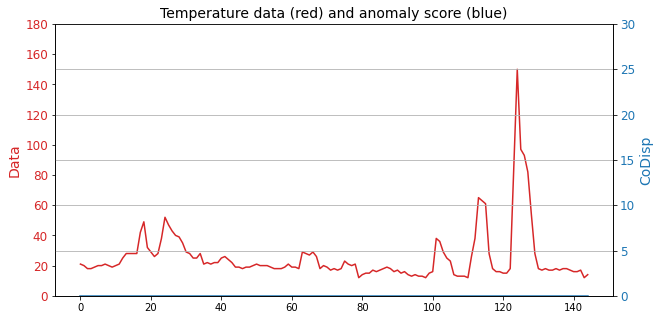

In [26]:
for index in range(len(avg_codisp)):
    avg_codisp[index]=avg_codisp[index]/50
fig, ax1 = plt.subplots(figsize=(10, 5))
color = 'tab:red'
ax1.set_ylabel('Data', color=color, size=14)
ax1.plot(turbidity_train, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(0,30)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0, 30)
plt.title('Turbidity data (red) and anomaly score (blue)', size=14)